In [1]:
%matplotlib inline
import numpy as np
import quantecon as qe
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,6)

### Compiling Functions

#### An Example

In [2]:
α = 4.0

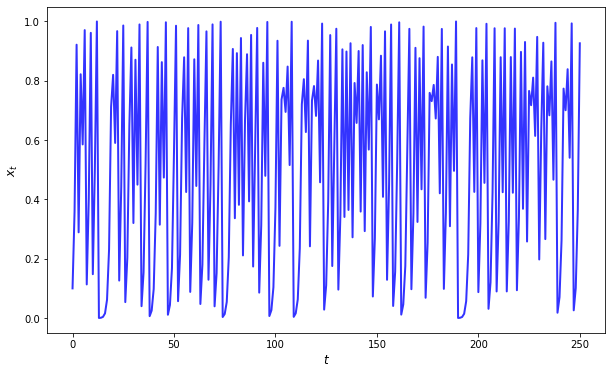

In [3]:
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    
    for t in range(n):
        x[t+1] = α * x[t] * (1 - x[t])
    
    return x

x = qm(0.1, 250)
fig, ax = plt.subplots()
ax.plot(x, 'b-', lw=2, alpha=0.8)
ax.set_xlabel('$t$', fontsize=12)
ax.set_ylabel('$x_{t}$', fontsize = 12)
plt.show()

In [4]:
from numba import jit

qm_numba = jit(qm)

In [5]:
n = 10_000_000
qe.tic()
qm(0.1, int(n))
time1 = qe.toc()

TOC: Elapsed: 0:00:6.05


In [6]:
qe.tic()
qm_numba(0.1, int(n))
time2 = qe.toc()

TOC: Elapsed: 0:00:0.31


In [7]:
qe.tic()
qm_numba(0.1, int(n))
time3 = qe.toc()

TOC: Elapsed: 0:00:0.04


In [8]:
time1 / time3 # Calculate speed gain

121.47027076122913

### Decorators and “nopython” Mode

In [9]:
qm_numba = jit(qm)

#### Decorator Notation

In [ ]:
@jit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    
    for t in range(n):
        x[t+1] = α * x[t] * (1 - x[t])
    
    return x

In [ ]:
qm(0.1, 10)

#### Type Inference and “nopython” Mode

In [ ]:
from numba import njit

@njit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    
    return x

#### Compiling Classes